<a href="https://colab.research.google.com/github/BrunoCavagnaro/DiplomadoDSML/blob/master/DataPreprocesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea Preprocesamiento de datos

## Librerias

In [1]:
!pip install feature-engine
!pip install kaggle

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import preprocessing
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler
from feature_engine import discretisers as dsc
from feature_engine import variable_transformers as vt

## Importar Data

### Conectar a Kaggle

In [3]:
##SOLO EJECUTA ESTE CÓDIGO UNA VEZ
##El dataset se encuentra en Kaggle, debido a su tamaño y por facilidad preferi solo importarlo. Si desean utilizarlo generen su API token de Kaggle,
##para mayor detalle leer el siguiente post: https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/.kaggle"#.kaggle es la carpeta donde he guardado el token. 
%cd '/content/gdrive/My Drive/.kaggle'

/content/gdrive/My Drive/.kaggle


In [5]:
#!kaggle datasets download -d orgesleka/used-cars-database #datasets usados
#link de dataset:https://www.kaggle.com/orgesleka/used-cars-database?select=cnt_km_year_powerPS_minPrice_maxPrice_avgPrice_sdPrice.csv

In [6]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

### Datasets y Estadisticos Descriptivos


In [7]:
df = pd.read_csv('autos.csv', encoding='latin1')

In [8]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

In [10]:
df.isnull().sum() 

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

## Missing & Outliers

### Evaluar correlaciones entre missing values

In [11]:
#notRepairedDamage es por mucho el feature con mayor numero de missing values, por tanto se decidio realizar una 
#inspección a los valores de este feature: 
df.groupby('notRepairedDamage')['notRepairedDamage'].count()

notRepairedDamage
ja       36286
nein    263182
Name: notRepairedDamage, dtype: int64

In [12]:
#la documentación dice que este feature refiere a si este vehiculo presenta una reparación que no ha sido reparada
#(ja significa si y nein no en Aleman), al ser un dataset de auto usados, es correcto asumir que los valores en NaN
#hacen referencia a vehiculos que no presentaban ningun daño para reparar. Por tanto estos valores NaN en realidad serían
#una nueva categoria (estos datos no pueden ser eliminados), la cual llamaremos Gut(bien en aleman)
df['notRepairedDamage'] = df['notRepairedDamage'].fillna(value='Gut')

In [13]:
df.groupby('notRepairedDamage')['notRepairedDamage'].count()

notRepairedDamage
Gut      72060
ja       36286
nein    263182
Name: notRepairedDamage, dtype: int64

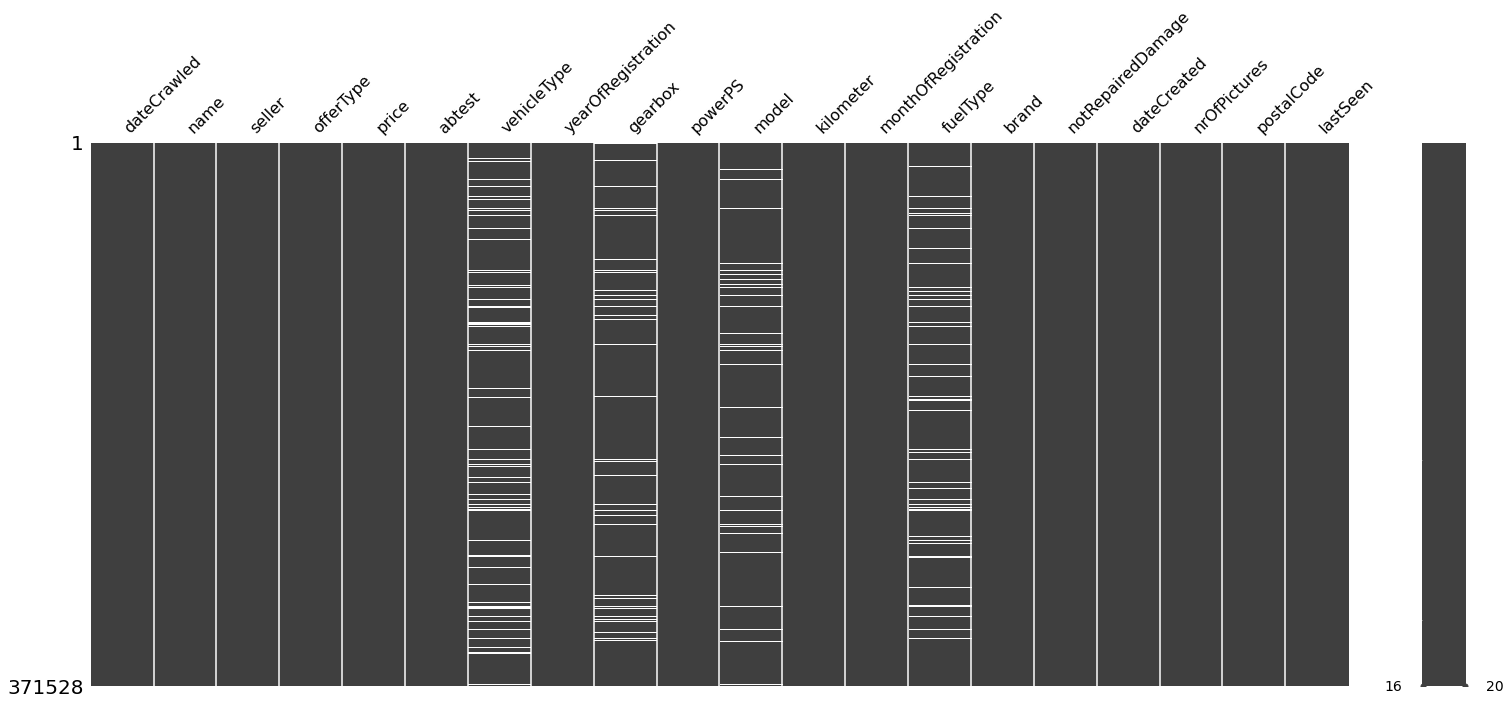

In [14]:
msno.matrix(df)

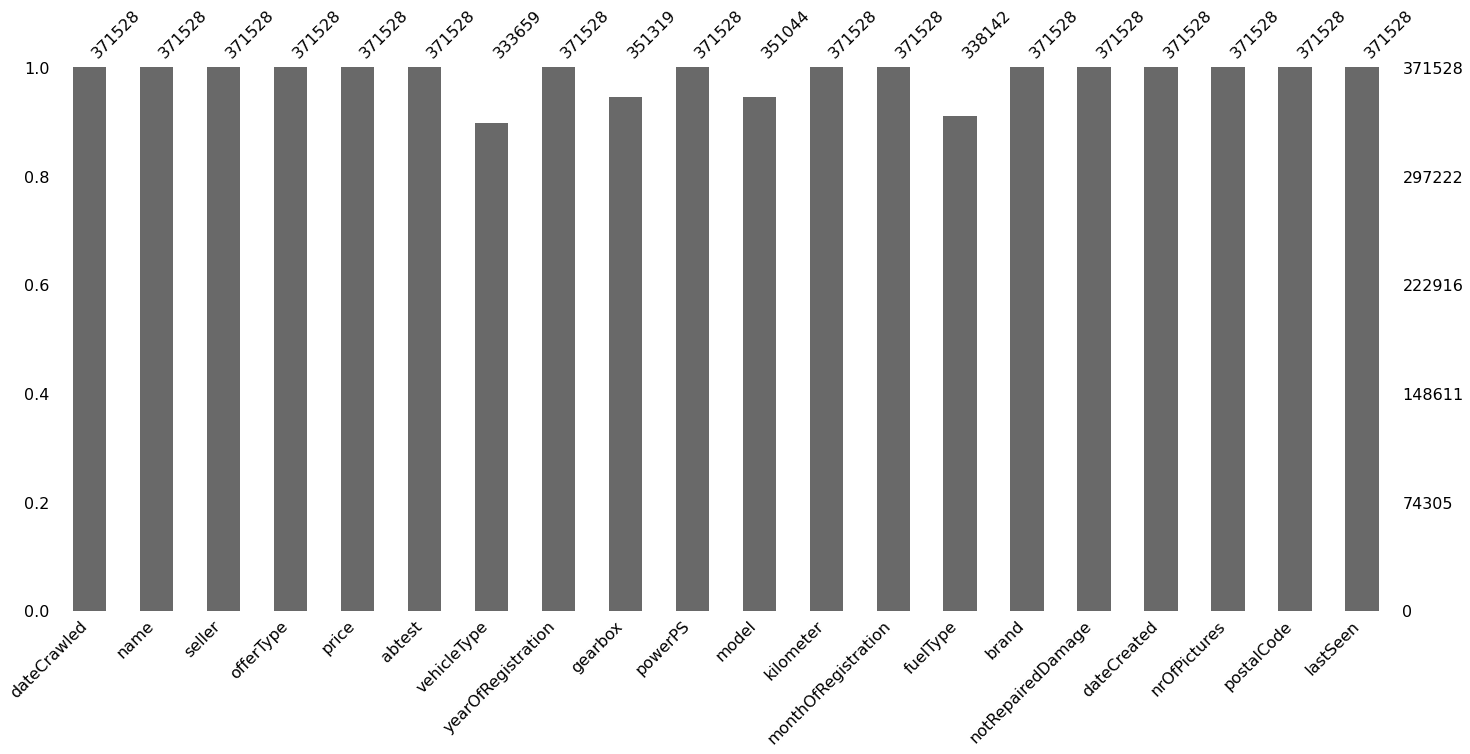

In [15]:
msno.bar(df)

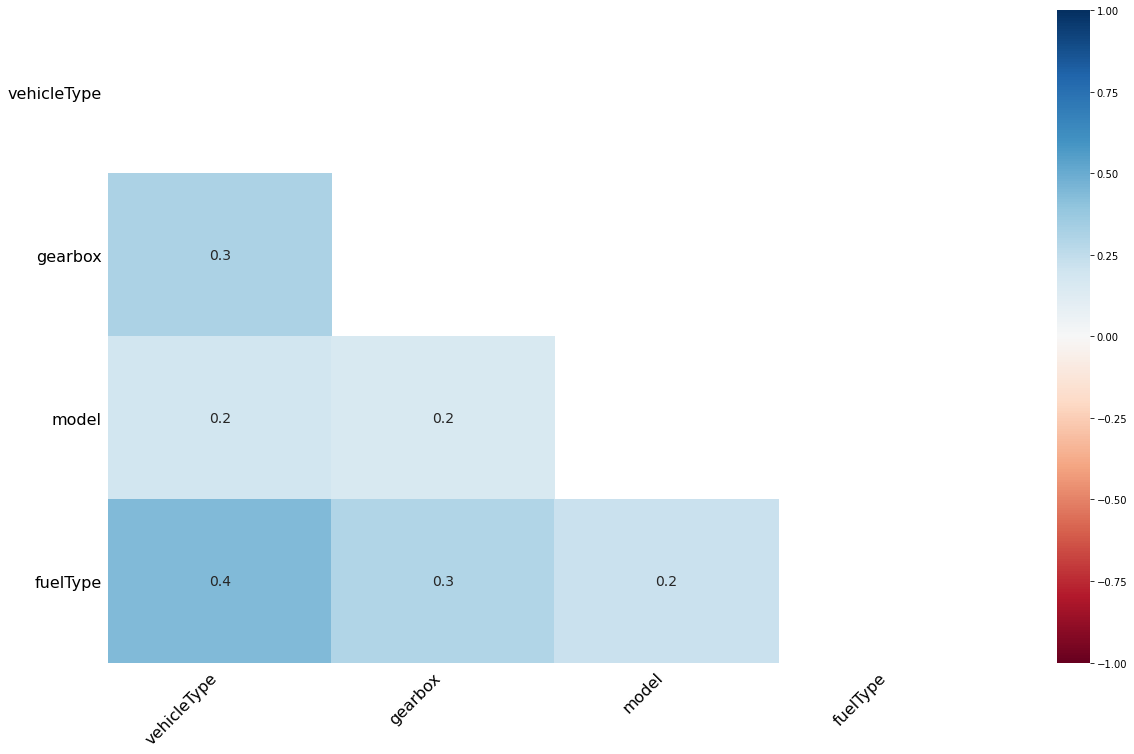

In [16]:
msno.heatmap(df) 

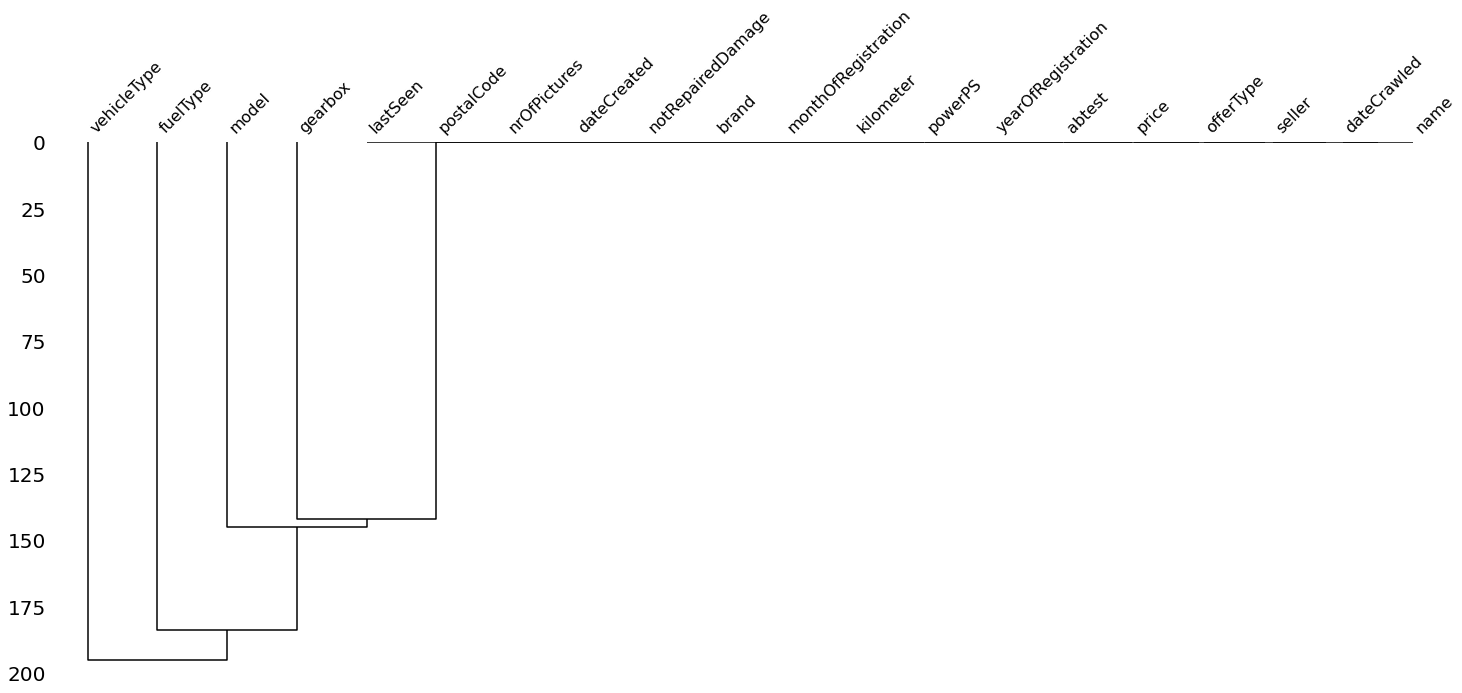

In [17]:
#observando el heatmap de correlación entre los missing values, vemos que entre estos hay una (relativa) correlación entre estos.
#en la matriz de nullity también aparenta haber cierta correlación entre estos datos faltantes. 
#posiblemente estos missing seal del tipo: MNAR (Missing not at Random) o MAR (Missing at Random);
#Como los coeficientes no son muy altos (ninguno supera el 0.5), se asume que estos son del tipo MAR.
#más info: https://towardsdatascience.com/missing-data-cfd9dbfd11b7
#para complementar se usara un dendograma
msno.dendrogram(df)

In [18]:
#Usando missigno hemos visto una ligera correlación entre los NaN, sin embargo estos features representan categorias,
#por tanto es mejor que sean inspeccionadas 
print(df.groupby('vehicleType')['vehicleType'].count()) 
print(df.groupby('gearbox')['gearbox'].count())
print(df.groupby('model')['model'].count().sort_values(ascending=False))
print(df.groupby('fuelType')['fuelType'].count())

vehicleType
andere         3357
bus           30201
cabrio        22898
coupe         19015
kleinwagen    80023
kombi         67564
limousine     95894
suv           14707
Name: vehicleType, dtype: int64
gearbox
automatik     77105
manuell      274214
Name: gearbox, dtype: int64
model
golf               30070
andere             26400
3er                20567
polo               13092
corsa              12573
                   ...  
serie_2                8
rangerover             6
serie_3                4
serie_1                2
discovery_sport        1
Name: model, Length: 251, dtype: int64
fuelType
andere        208
benzin     223857
cng           571
diesel     107746
elektro       104
hybrid        278
lpg          5378
Name: fuelType, dtype: int64


In [19]:
#Como vemos, todos estos features hacen referencia a categorias que no pueden ser imputables. Por tanto el único tratamiento
#que se podría realizar, es eliminarlas.
#estos NaN, representan un 20% de la data, a pesar de no ser una infima de los datos, no existe una alternativa para hacer una
#imputación. En un escenario real, se debería evaluar la fuente de los datos, para identificar razones por las cuales hay missing
#values y obtener mejor data
m_1 = df[df['vehicleType'].notna()]
m_2 = m_1[m_1['gearbox'].notna()]
m_3 = m_2[m_2['model'].notna()]
m_f = m_3[m_3['fuelType'].notna()]
m_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299864 entries, 2 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          299864 non-null  object
 1   name                 299864 non-null  object
 2   seller               299864 non-null  object
 3   offerType            299864 non-null  object
 4   price                299864 non-null  int64 
 5   abtest               299864 non-null  object
 6   vehicleType          299864 non-null  object
 7   yearOfRegistration   299864 non-null  int64 
 8   gearbox              299864 non-null  object
 9   powerPS              299864 non-null  int64 
 10  model                299864 non-null  object
 11  kilometer            299864 non-null  int64 
 12  monthOfRegistration  299864 non-null  int64 
 13  fuelType             299864 non-null  object
 14  brand                299864 non-null  object
 15  notRepairedDamage    299864 non-nu

### Outliers

In [20]:
#Para identificar a los Outliers, utilizaremos 3 métodos para detectarlos:
#Rango Intercuartilico, Z Score y Distancia de Mahalanobis
#Luego analizaremos los 3 métodos y seleccionaremos uno de estos para eliminar los outliers
df = m_f

{'boxes': [<matplotlib.lines.Line2D at 0x7f2c7e22bac8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2c7e23d518>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c7e23df98>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c7e23dc18>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2c7e22bdd8>,
  <matplotlib.lines.Line2D at 0x7f2c7e23d198>]}

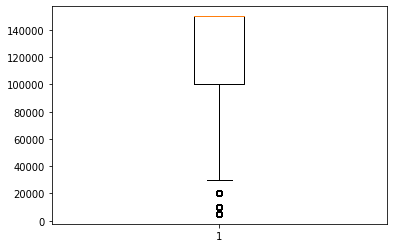

In [21]:
#NO SE ANALIZARÁN LAS VARIABLES DE CÓDIGO POSTAL Y monthOfRegistration POR OBVIAS RAZONES. 
#DEACUERDO A LA DOCUMENTACIÓN LA COLUMNA nrOfPictures contiene solamente 0s, por lo tanto será eliminada.
df = df.drop('nrOfPictures', axis=1)
#plt.boxplot(df["price"])
#plt.boxplot(df["yearOfRegistration"])
#plt.boxplot(df["powerPS"])
plt.boxplot(df["kilometer"])            

In [22]:
#Rango Intercuartilico price  
iqr_price = df["price"].quantile(0.75) - df["price"].quantile(0.25)
df["price_out"]=(df["price"]< np.percentile(df["price"], 25)-1.5*iqr_price) | (df["price"]> np.percentile(df["price"], 75)+1.5*iqr_price)
print(df[df["price_out"]==True])

#Rango Intercuartilico yearOfRegistration  
iqr_year = df["yearOfRegistration"].quantile(0.75) - df["yearOfRegistration"].quantile(0.25)
df["yearOfRegistration_out"]=(df["yearOfRegistration"]< np.percentile(df["yearOfRegistration"], 25)-1.5*iqr_year) | (df["yearOfRegistration"]> np.percentile(df["yearOfRegistration"], 75)+1.5*iqr_year)
print(df[df["yearOfRegistration_out"]==True])

#Rango Intercuartilico powerPS 
iqr_power = df["powerPS"].quantile(0.75) - df["powerPS"].quantile(0.25)
df["powerPS_out"]=(df["powerPS"]< np.percentile(df["powerPS"], 25)-1.5*iqr_power) | (df["powerPS"]> np.percentile(df["powerPS"], 75)+1.5*iqr_power)
print(df[df["powerPS_out"]==True])

#Rango Intercuartilico kilometer 
iqr_kilometer = df["kilometer"].quantile(0.75) - df["kilometer"].quantile(0.25)
df["kilometer_out"]=(df["kilometer"]< np.percentile(df["kilometer"], 25)-1.5*iqr_kilometer) | (df["kilometer"]> np.percentile(df["kilometer"], 75)+1.5*iqr_kilometer)
print(df[df["kilometer_out"]==True])

                dateCrawled  ... price_out
14      2016-03-21 12:57:01  ...      True
33      2016-03-25 21:48:47  ...      True
56      2016-03-21 01:59:07  ...      True
80      2016-03-11 23:42:53  ...      True
98      2016-03-31 10:53:10  ...      True
...                     ...  ...       ...
371474  2016-03-25 17:48:10  ...      True
371477  2016-03-07 16:50:15  ...      True
371483  2016-03-07 09:54:08  ...      True
371500  2016-03-21 23:40:49  ...      True
371527  2016-03-07 19:39:19  ...      True

[21280 rows x 20 columns]
                dateCrawled  ... yearOfRegistration_out
7       2016-03-21 18:54:38  ...                   True
28      2016-03-09 11:56:38  ...                   True
39      2016-03-25 15:50:30  ...                   True
93      2016-04-02 23:25:25  ...                   True
192     2016-03-31 16:57:18  ...                   True
...                     ...  ...                    ...
371132  2016-03-31 00:50:02  ...                   True
371312  2

In [23]:
#Z Score price
p1=preprocessing.scale(df["price"])
df["price_out2"]=(abs(p1)>3)
print(df[df["price_out2"]==True])

#Z Score yearOfRegistration
p2=preprocessing.scale(df["yearOfRegistration"])
df["yearOfRegistration_out2"]=abs(p2)>3
print(df[df["yearOfRegistration_out2"]==True])

#Z Score powerPS
p3=preprocessing.scale(df["powerPS"])
df["powerPS_out2"]=abs(p3)>3
print(df[df["powerPS_out2"]==True])

#Z Score kilometer
p4=preprocessing.scale(df["kilometer"])
df["kilometer_out2"]=abs(p4)>3
print(df[df["kilometer_out2"]==True])

                dateCrawled  ... price_out2
14663   2016-04-03 06:03:56  ...       True
21467   2016-03-19 19:45:02  ...       True
54295   2016-03-08 11:51:40  ...       True
77520   2016-03-22 14:58:27  ...       True
87799   2016-03-08 20:39:05  ...       True
91106   2016-03-30 19:46:05  ...       True
127769  2016-03-28 12:51:51  ...       True
127820  2016-03-14 17:49:54  ...       True
139052  2016-03-14 12:49:48  ...       True
183361  2016-03-26 11:51:20  ...       True
210657  2016-03-12 21:50:57  ...       True
241847  2016-03-31 18:56:54  ...       True
251980  2016-03-21 22:25:19  ...       True
279937  2016-04-03 11:56:00  ...       True
280059  2016-03-05 20:49:28  ...       True
287835  2016-03-26 00:56:36  ...       True

[16 rows x 24 columns]
                dateCrawled  ... yearOfRegistration_out2
7       2016-03-21 18:54:38  ...                    True
28      2016-03-09 11:56:38  ...                    True
192     2016-03-31 16:57:18  ...                    True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


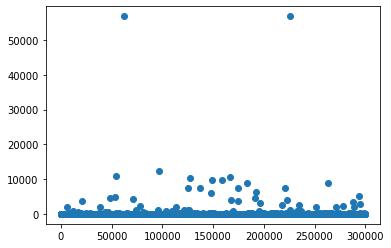

In [24]:
#Mahalanobis Distance
df_m = df[["price", "yearOfRegistration", "powerPS", "kilometer"]]

#matriz de covarianzas
Sx = df_m.cov().values
#inversa de la matriz de covarianzas
Sx = sp.linalg.inv(Sx)

mean = df_m.mean().values

def mahalanobisR(X,meanCol,IC):
    m = []
    for i in range(X.shape[0]):
        m.append(mahalanobis(X.iloc[i,:],meanCol,IC) ** 2)
    return(m)

mR = pd.DataFrame(mahalanobisR(df_m,mean,Sx), columns = ['mR'])
df_m['mr']=mR
df_m['index'] = df_m.index
plt.scatter(df_m["index"],df_m['mr'])

In [25]:
df_m['out'] = df_m["mr"]>8
print(df_m[df_m["out"]==True])

        price  yearOfRegistration  powerPS  kilometer         mr   index   out
5         650                1995      102     150000  26.049500       5  True
20      10400                2009      160     100000  32.507539      20  True
117      6300                2002      265     150000   9.826663     117  True
118      3500                1991      160     150000  16.683720     118  True
135      2750                2001      131     150000   9.275658     135  True
...       ...                 ...      ...        ...        ...     ...   ...
299682  15800                2009      184     150000  11.693255  299682  True
299690   5000                2006      476     150000  10.189469  299690  True
299695    300                1998        0     150000   9.059615  299695  True
299806   3800                2004       75      90000  15.547907  299806  True
299819  26900                2011      184      70000  60.905827  299819  True

[9267 rows x 7 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
#ANALISIS 3 MÉTODOS: 
#Después de ver los 3 análisis y también revisar la documentación he concluido que hay un exceso de outliers en las 4 
#columnas, de manera individual no solo multivariable(por tanto el método de Mahanalobis no es óptimo).
#He seleccionado como métod de eliminación de outliers al Rango Intercuartílico debido a la robustes del método.   
indexNames_prices = df[ df['price_out'] == True ].index
df.drop(indexNames_prices , inplace=True)

indexNames_year = df[ df['yearOfRegistration_out'] == True ].index
df.drop(indexNames_year , inplace=True)

indexNames_power = df[ df['powerPS_out'] == True ].index
df.drop(indexNames_power , inplace=True)

indexNames_kilometer = df[ df['kilometer_out'] == True ].index
df.drop(indexNames_kilometer , inplace=True)
							
df = df.drop('price_out', axis=1)
df = df.drop('yearOfRegistration_out', axis=1)
df = df.drop('powerPS_out', axis=1)
df = df.drop('kilometer_out', axis=1)
df = df.drop('price_out2', axis=1)
df = df.drop('yearOfRegistration_out2', axis=1)
df = df.drop('powerPS_out2', axis=1)
df = df.drop('kilometer_out2', axis=1)
df


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,Gut,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,Angebot,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,privat,Angebot,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,67112,2016-04-05 18:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,2016-03-19 19:53:49,turbo_defekt,privat,Angebot,3200,control,limousine,2004,manuell,225,leon,150000,5,benzin,seat,ja,2016-03-19 00:00:00,96465,2016-03-19 20:44:43
371521,2016-03-27 20:36:20,Opel_Zafira_1.6_Elegance_TÜV_12/16,privat,Angebot,1150,control,bus,2000,manuell,0,zafira,150000,3,benzin,opel,nein,2016-03-27 00:00:00,26624,2016-03-29 10:17:23
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein,2016-03-05 00:00:00,26135,2016-03-11 18:17:12
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein,2016-03-19 00:00:00,87439,2016-04-07 07:15:26


{'boxes': [<matplotlib.lines.Line2D at 0x7f2c7e17a7b8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2c7e186208>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c7e186c88>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c7e186908>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2c7e17aac8>,
  <matplotlib.lines.Line2D at 0x7f2c7e17ae48>]}

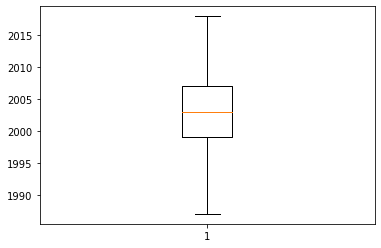

In [27]:
#plt.boxplot(df["price"])
plt.boxplot(df["yearOfRegistration"])
#plt.boxplot(df["powerPS"])
#plt.boxplot(df["kilometer"]) 

## Estandarización y Escalamiento

### Factores Categoricos

In [28]:
#Primero analizaremos las columnas que previamente no han sido evaluadas: 
print(df.groupby('seller')['seller'].count()) #Al ser un feature con datos DEMASIADO disparejos se ha decidido eliminar 
#la columna, PD: gewerblich es comercial y privat es privado.
df = df.drop('seller', axis=1)
print(df.groupby('offerType')['offerType'].count())#Al ser un feature con datos DEMASIADO disparejos se ha decidido eliminar 
#la columna, PD: gesuch es solicitud y angebot es oferta.
df = df.drop('offerType', axis=1)
print(df.groupby('abtest')['abtest'].count())#esta columna hace referencia a alguna prueba AB test que puede haber
#realizado eBay sobre el anuncio de este vehiculo. Esta correctamente balanceado. 
print(df.groupby('brand')['brand'].count())
#en brand se puede ver que no hay errores o datos mal catalogados por tanto se decide dejar esta columna como esta.

seller
gewerblich         2
privat        264143
Name: seller, dtype: int64
offerType
Angebot    264141
Gesuch          4
Name: offerType, dtype: int64
abtest
control    127149
test       136996
Name: abtest, dtype: int64
brand
alfa_romeo        1781
audi             22384
bmw              28290
chevrolet         1207
chrysler          1105
citroen           3997
dacia              723
daewoo             397
daihatsu           601
fiat              6958
ford             19123
honda             2132
hyundai           2828
jaguar             304
jeep               501
kia               1929
lada               126
lancia             329
land_rover         400
mazda             4399
mercedes_benz    23815
mini              2652
mitsubishi        2276
nissan            3743
opel             29742
peugeot           8659
porsche            263
renault          13361
rover              315
saab               428
seat              5310
skoda             4579
smart             3583
subaru       

In [29]:
#Features Binarias:
#Binaria ABTest
df['abtest'] = df['abtest'].replace(to_replace= 1, value = 0)
df['abtest'] = df['abtest'].replace(to_replace='test', value = 1)
#Binaria gearbox
df['gearbox'] = df['gearbox'].replace(to_replace= 'manuell', value = 0)
df['gearbox'] = df['gearbox'].replace(to_replace='automatik', value = 1)

In [30]:
#Features no Binarias: 
#vehicleType: Esta columna posee en total 8 categorias, las cuales a pesar de ser altas no es necesario agregarlas.
"""vehicleType
  andere         2210
  bus           25147
  cabrio        16397
  coupe         11914
  kleinwagen    66977
  kombi         56213
  limousine     76325
  suv """
#fuelType: Esta columna hace referencia al tipo de combustible que usa el vehiculo, debido a  que existe disparidad entre
#estos, he decidido agruparlos en los siguientes grupos: (benzin) = gasolina, (diesel) = diesel , (andere, cng, elektro, 
#hybrid,lpg) = alternativa
df['fuelType'] = df['fuelType'].replace(to_replace= 'benzin', value = 'gasolina')
df['fuelType'] = df['fuelType'].replace(to_replace= 'andere', value = 'alternativa')
df['fuelType'] = df['fuelType'].replace(to_replace= 'cng', value = 'alternativa')
df['fuelType'] = df['fuelType'].replace(to_replace= 'elektro', value = 'alternativa')
df['fuelType'] = df['fuelType'].replace(to_replace= 'hybrid', value = 'alternativa')
df['fuelType'] = df['fuelType'].replace(to_replace= 'lpg', value = 'alternativa')
print(df.groupby('fuelType')['fuelType'].count())

#notRepairedDamage: Esta columna tiene 3 categorias, las cuales pueden permanecer ya que no pueden agregarse. 
"""
notRepairedDamage
Gut      35686
ja       26354
nein    202105
"""

fuelType
alternativa      4870
diesel          83523
gasolina       175752
Name: fuelType, dtype: int64


'\nnotRepairedDamage\nGut      35686\nja       26354\nnein    202105\n'

In [31]:
#One Hot Encoding: 
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
"""
notRepairedDamage:

"""
a_1 = np.array(df[['notRepairedDamage']]) 
lr_1 = LabelEncoder()
a_1 = lr_1.fit_transform(a_1)
cat_1 = to_categorical(a_1)
cat_1 = np.delete(cat_1, 2, 1)
df_repo_1 = pd.DataFrame(data=cat_1, columns=["NRD1", "NRD2"])

"""vehicleType
  andere         2210
  bus           25147
  cabrio        16397
  coupe         11914
  kleinwagen    66977
  kombi         56213
  limousine     76325
  suv """

a_2 = np.array(df[['vehicleType']])
lr_2 = LabelEncoder()
a_2 = lr_2.fit_transform(a_2)
cat_2 = to_categorical(a_2)
cat_2 = np.delete(cat_2, 7, 1)
df_repo_2 = pd.DataFrame(data=cat_2, columns=["VT1", "VT2", "VT3", "VT4", "VT5", "VT6", "VT7"])

"""fuelType"""
a_3 = np.array(df[['fuelType']])
lr_3 = LabelEncoder()
a_3 = lr_3.fit_transform(a_3)
cat_3 = to_categorical(a_3)
cat_3 = np.delete(cat_3, 2, 1)
df_repo_3 = pd.DataFrame(data=cat_3, columns=["FT1", "FT2"])

df_cd = df_repo_1.join(df_repo_2)
df_cd = df_cd.join(df_repo_3)
print(df_cd)

df = df.join(df_cd)
print(df)
df = df.drop('notRepairedDamage', axis=1)  
df = df.drop('vehicleType', axis=1)
df = df.drop('fuelType', axis=1)
df

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


        NRD1  NRD2  VT1  VT2  VT3  VT4  VT5  VT6  VT7  FT1  FT2
0        1.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1        0.0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2        0.0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
3        0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4        0.0   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
...      ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
264140   0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
264141   0.0   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
264142   0.0   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
264143   0.0   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
264144   1.0   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0

[264145 rows x 11 columns]
                dateCrawled  ...  FT2
2       2016-03-14 12:52:21  ...  1.0
3       2016-03-17 16:54:04  ...  0.0
4       2016-03-31 17:25:20  ...  0.0
5       2016-04-04 17:36:23  ...  0.0
6       2016-0

,dateCrawled,name,price,abtest,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,brand,dateCreated,postalCode,lastSeen,NRD1,NRD2,VT1,VT2,VT3,VT4,VT5,VT6,VT7,FT1,FT2
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",9800,1,2004,1,163,grand,125000,8,jeep,2016-03-14 00:00:00,90480,2016-04-05 12:47:46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,1,2001,0,75,golf,150000,6,volkswagen,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,3600,1,2008,0,69,fabia,90000,7,skoda,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,1,1995,0,102,3er,150000,10,bmw,2016-04-04 00:00:00,33775,2016-04-06 19:17:07,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,2200,1,2004,0,109,2_reihe,150000,8,peugeot,2016-04-01 00:00:00,67112,2016-04-05 18:18:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,2016-03-19 19:53:49,turbo_defekt,3200,control,2004,0,225,leon,150000,5,seat,2016-03-19 00:00:00,96465,2016-03-19 20:44:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371521,2016-03-27 20:36:20,Opel_Zafira_1.6_Elegance_TÜV_12/16,1150,control,2000,0,0,zafira,150000,3,opel,2016-03-27 00:00:00,26624,2016-03-29 10:17:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,1199,1,2000,1,101,fortwo,125000,3,smart,2016-03-05 00:00:00,26135,2016-03-11 18:17:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,9200,1,1996,0,102,transporter,150000,3,volkswagen,2016-03-19 00:00:00,87439,2016-04-07 07:15:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Discretización Features Continuos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


         powerPS_OR
powerPS            
0              3069
1            328780
2           3641042
3           4180447
4           6436644
5           5814902
6           4141334
7           2226231
8           1945132
9            575251
262
         powerPS_N
powerPS           
0            15085
1             6989
2            54777
3            44630
4            55275
5            40501
6            24448
7            11428
8             8686
9             2326
AxesSubplot(0.125,0.125;0.775x0.755)
                    yearOfRegistration_OR
yearOfRegistration                       
0                                 7534097
1                                14791098
2                                38219160
3                                92172642
4                               101082400
5                               103498346
6                                91334552
7                                60902541
8                                19169181
9                            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


        price_OR
price           
0       81552764
1      150630488
2      148416791
3      156274274
4      139022418
5      122375599
6      111618387
7       95592404
8       92335971
9       65973737
17890
       price_N
price         
0        90416
1        58209
2        33823
3        25112
4        17335
5        12560
6         9608
7         7120
8         6073
9         3889
AxesSubplot(0.125,0.125;0.775x0.755)
           kilometer_OR
kilometer              
0             251960000
1             242800000
2             355440000
3             481670000
4            1483890000
5            1144100000
7            3653375000
9           27197100000
150000
           kilometer_N
kilometer             
0                 7121
1                 4856
2                 5924
3                 6881
4                17381
5                11441
7                29227
9               181314
AxesSubplot(0.125,0.125;0.775x0.755)


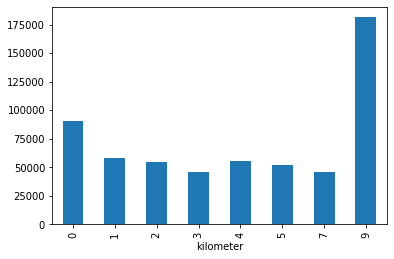

In [32]:
#Discretizar variables continuas suele ser recomendable en escenarios en los que desees crear un modelo para clasificación. 
#y normalizarlo para regresión o en algunos clasificadores (dependerá de lo que represente la variable)
#Es por eso que he decidio que para mis variables númericas aplicar ambos métodos, los cuales serán guardados en dos 
#dataframes distintos: df_disc_f, df_norm

df_disc = df[['powerPS', 'yearOfRegistration', 'price', 'kilometer']]


"""
powerPS

"""
df_disc["powerPS_OR"]=df_disc["powerPS"]
disc1 = dsc.EqualWidthDiscretiser(bins=10, variables=['powerPS'])
disc1.fit(df_disc)
df_disc_t1= disc1.transform(df_disc)
df_disc_t1["powerPS_N"]=1
double_group_1 = df_disc_t1.groupby(["powerPS"])
double_group_1.sum()
print(double_group_1.sum()[["powerPS_OR"]])
print(max(df_disc["powerPS_OR"]))
print(double_group_1.sum()[["powerPS_N"]])
print(df_disc_t1.groupby('powerPS')['powerPS'].count().plot.bar())

"""
yearOfRegistration

"""
df_disc["yearOfRegistration_OR"]=df_disc["yearOfRegistration"]
disc2 = dsc.EqualWidthDiscretiser(bins=10, variables=['yearOfRegistration'])
disc2.fit(df_disc)
df_disc_t2= disc2.transform(df_disc)
df_disc_t2["yearOfRegistration_N"]=1
double_group_2 = df_disc_t2.groupby(["yearOfRegistration"])
double_group_2.sum()
print(double_group_2.sum()[["yearOfRegistration_OR"]])
print(max(df_disc["yearOfRegistration_OR"]))
print(double_group_2.sum()[["yearOfRegistration_N"]])
print(df_disc_t2.groupby('yearOfRegistration')['yearOfRegistration'].count().plot.bar())

"""
price

"""
df_disc["price_OR"]=df_disc["price"]
disc3 = dsc.EqualWidthDiscretiser(bins=10, variables=['price'])
disc3.fit(df_disc)
df_disc_t3= disc3.transform(df_disc)
df_disc_t3["price_N"]=1
double_group_3 = df_disc_t3.groupby(["price"])
double_group_3.sum()
print(double_group_3.sum()[["price_OR"]])
print(max(df_disc["price_OR"]))
print(double_group_3.sum()[["price_N"]])
print(df_disc_t3.groupby('price')['price'].count().plot.bar())


"""
kilometer

"""
df_disc["kilometer_OR"]=df_disc["kilometer"]
disc4 = dsc.EqualWidthDiscretiser(bins=10, variables=['kilometer'])
disc4.fit(df_disc)
df_disc_t4= disc4.transform(df_disc)
df_disc_t4["kilometer_N"]=1
df_disc_t4
double_group_4 = df_disc_t4.groupby(["kilometer"])
double_group_4.sum()
print(double_group_4.sum()[["kilometer_OR"]])
print(max(df_disc["kilometer_OR"]))
print(double_group_4.sum()[["kilometer_N"]])
print(df_disc_t4.groupby('kilometer')['kilometer'].count().plot.bar())


In [34]:
df_disc_f = df
df_disc_f['powerPS'] = df_disc_t1['powerPS']
df_disc_f['yearOfRegistration'] = df_disc_t2['yearOfRegistration']
df_disc_f['price'] = df_disc_t3['price']
df_disc_f['kilometer'] = df_disc_t4['kilometer']

df_disc_f 

,dateCrawled,name,price,abtest,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,brand,dateCreated,postalCode,lastSeen,NRD1,NRD2,VT1,VT2,VT3,VT4,VT5,VT6,VT7,FT1,FT2
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",5,1,5,1,6,grand,7,8,jeep,2016-03-14 00:00:00,90480,2016-04-05 12:47:46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,0,1,4,0,2,golf,9,6,volkswagen,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,2,1,6,0,2,fabia,4,7,skoda,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,0,1,2,0,3,3er,9,10,bmw,2016-04-04 00:00:00,33775,2016-04-06 19:17:07,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,1,1,5,0,4,2_reihe,9,8,peugeot,2016-04-01 00:00:00,67112,2016-04-05 18:18:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,2016-03-19 19:53:49,turbo_defekt,1,control,5,0,8,leon,9,5,seat,2016-03-19 00:00:00,96465,2016-03-19 20:44:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371521,2016-03-27 20:36:20,Opel_Zafira_1.6_Elegance_TÜV_12/16,0,control,4,0,0,zafira,9,3,opel,2016-03-27 00:00:00,26624,2016-03-29 10:17:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,0,1,4,1,3,fortwo,7,3,smart,2016-03-05 00:00:00,26135,2016-03-11 18:17:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,5,1,2,0,3,transporter,9,3,volkswagen,2016-03-19 00:00:00,87439,2016-04-07 07:15:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalización

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,powerPS,yearOfRegistration,price,kilometer,powerPS_ZS,powerPS_MM
2,6,5,5,7,1.161005,0.666667
3,2,4,0,9,-0.905091,0.222222
4,2,6,2,4,-0.905091,0.222222
5,3,2,0,9,-0.388567,0.333333
6,4,5,1,9,0.127957,0.444444
...,...,...,...,...,...,...
371520,8,5,1,9,2.194053,0.888889
371521,0,4,0,9,-1.938139,0.000000
371524,3,4,0,7,-0.388567,0.333333
371525,3,2,5,9,-0.388567,0.333333


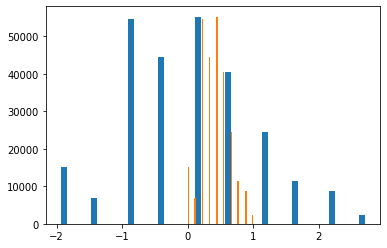

In [58]:
#P
df_norm = df[['powerPS', 'yearOfRegistration', 'price', 'kilometer']]
"""
powerPS

"""
#Normalización Z-score
df_norm["powerPS_ZS"]=preprocessing.scale(df_norm["powerPS"])
plt.hist(df_norm["powerPS_ZS"], bins = 50)

#Normalización MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
df_norm["powerPS_MM"]=scaler.fit_transform(df_norm[["powerPS"]])
plt.hist(df_norm["powerPS_MM"], bins = 50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(array([ 3788.,     0.,     0.,     0.,     0.,  7425.,     0.,     0.,
            0.,     0.,     0., 19155.,     0.,     0.,     0.,     0.,
        46129.,     0.,     0.,     0.,     0.,     0., 50516.,     0.,
            0.,     0.,     0., 51646.,     0.,     0.,     0.,     0.,
            0., 45510.,     0.,     0.,     0.,     0., 30302.,     0.,
            0.,     0.,     0.,     0.,  9525.,     0.,     0.,     0.,
            0.,   149.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

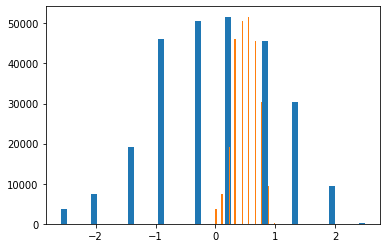

In [59]:
"""
yearOfRegistration

"""
#Normalización Z-score
df_norm["yearOfRegistration_ZS"]=preprocessing.scale(df_norm["yearOfRegistration"])
plt.hist(df_norm["yearOfRegistration_ZS"], bins = 50)

#Normalización MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
df_norm["yearOfRegistration_MM"]=scaler.fit_transform(df_norm[["yearOfRegistration"]])
plt.hist(df_norm["yearOfRegistration_MM"], bins = 50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(array([90416.,     0.,     0.,     0.,     0., 58209.,     0.,     0.,
            0.,     0.,     0., 33823.,     0.,     0.,     0.,     0.,
        25112.,     0.,     0.,     0.,     0.,     0., 17335.,     0.,
            0.,     0.,     0., 12560.,     0.,     0.,     0.,     0.,
            0.,  9608.,     0.,     0.,     0.,     0.,  7120.,     0.,
            0.,     0.,     0.,     0.,  6073.,     0.,     0.,     0.,
            0.,  3889.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

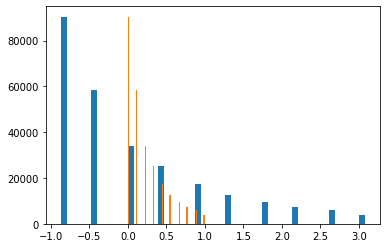

In [60]:
"""
price

"""
#Normalización Z-score
df_norm["price_ZS"]=preprocessing.scale(df_norm["price"])
plt.hist(df_norm["price_ZS"], bins = 50)

#Normalización MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
df_norm["price_MM"]=scaler.fit_transform(df_norm[["price"]])
plt.hist(df_norm["price_MM"], bins = 50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(array([  7121.,      0.,      0.,      0.,      0.,   4856.,      0.,
             0.,      0.,      0.,      0.,   5924.,      0.,      0.,
             0.,      0.,   6881.,      0.,      0.,      0.,      0.,
             0.,  17381.,      0.,      0.,      0.,      0.,  11441.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,  29227.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
        181314.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

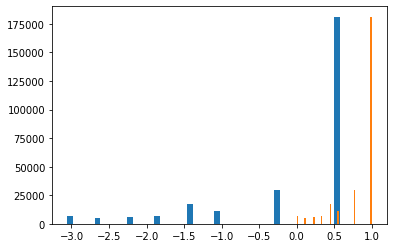

In [61]:
"""
kilometer

"""
#Normalización Z-score
df_norm["kilometer_ZS"]=preprocessing.scale(df_norm["kilometer"])
plt.hist(df_norm["kilometer_ZS"], bins = 50)

#Normalización MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
df_norm["kilometer_MM"]=scaler.fit_transform(df_norm[["kilometer"]])
plt.hist(df_norm["kilometer_MM"], bins = 50)

In [63]:
#Tras ver ambos medios de normalización aplicados a los features númericos se ha sacado estas conclusiones: 
#powerPS: Al haber una gran variedad de modelos y además un amplio rango de estos, considero que el método adecuado 
#es una normalización. 
#yearOfRegistration: Al haber una gran variedad de modelos y además un amplio rango de estos, considero que el método adecuado 
#es una normalización.
#price: Al haber mucha más proporción de precios bajos, considero que el método adecuado es MinMax
#kilometer: Al haber mucha más proporción de alto kilometraje, considero que el método adecuado es MinMax
 
df_norm_f = df
df_norm_f['powerPS'] = df_norm["powerPS_ZS"]
df_norm_f['yearOfRegistration'] = df_norm["yearOfRegistration_ZS"]
df_norm_f['price'] = df_norm["price_MM"]
df_norm_f['kilometer'] = df_norm["kilometer_MM"]

df_norm_f 

,dateCrawled,name,price,abtest,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,brand,dateCreated,postalCode,lastSeen,NRD1,NRD2,VT1,VT2,VT3,VT4,VT5,VT6,VT7,FT1,FT2
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",0.555556,1,0.243056,1,1.161005,grand,0.777778,8,jeep,2016-03-14 00:00:00,90480,2016-04-05 12:47:46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,0.000000,1,-0.322133,0,-0.905091,golf,1.000000,6,volkswagen,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,0.222222,1,0.808245,0,-0.905091,fabia,0.444444,7,skoda,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,0.000000,1,-1.452511,0,-0.388567,3er,1.000000,10,bmw,2016-04-04 00:00:00,33775,2016-04-06 19:17:07,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,0.111111,1,0.243056,0,0.127957,2_reihe,1.000000,8,peugeot,2016-04-01 00:00:00,67112,2016-04-05 18:18:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,2016-03-19 19:53:49,turbo_defekt,0.111111,control,0.243056,0,2.194053,leon,1.000000,5,seat,2016-03-19 00:00:00,96465,2016-03-19 20:44:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371521,2016-03-27 20:36:20,Opel_Zafira_1.6_Elegance_TÜV_12/16,0.000000,control,-0.322133,0,-1.938139,zafira,1.000000,3,opel,2016-03-27 00:00:00,26624,2016-03-29 10:17:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,0.000000,1,-0.322133,1,-0.388567,fortwo,0.777778,3,smart,2016-03-05 00:00:00,26135,2016-03-11 18:17:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,0.555556,1,-1.452511,0,-0.388567,transporter,1.000000,3,volkswagen,2016-03-19 00:00:00,87439,2016-04-07 07:15:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
